* Goals for today
    * QICK: pulse generation and readout for qubits - link to Alex and Sara’s presentations
    * Up- and down-conversion
    * Mixers (RF board, but can also be discrete)
* Out of scope for today
    * Other RFSoC applications
        * CW measurement: MKIDs, BREAD
        * Full-speed (not downconverted) readout
    * Details
        * Feedback (see demos!)
        * Other gens and ROs: multiplexing, interpolation (ask us!)
        * Safe programming: timing, frequency matching, time units (see docs!)
* What is the RFSoC?
    * High-speed DAC and ADC
    * FPGA
    * CPU
    * Off-the-shelf eval boards
* What is QICK?
    * Firmware (standard firmware + on request)
    * Software library
    * Documentation (demos + docs)
* Connecting to rfsoc
    * It’s a Raspberry Pi
    * Local notebook, or Pyro (or cloud?)
* Initial setup of rfsoc
    * SD image
    * Network - talk to me if you're putting one on the Fermilab network
    * QICK repo (includes library + standard firmware) https://github.com/openquantumhardware/qick
* How to approach the QICK
    * It's easy to play around - it costs you very little to just try something in a notebook
        * We can provide remote access to a shared board
    * Dig deep - you can see and modify all the (Python) backend code, and even the firmware

In [32]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from matplotlib import colors
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/share/pynq-venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


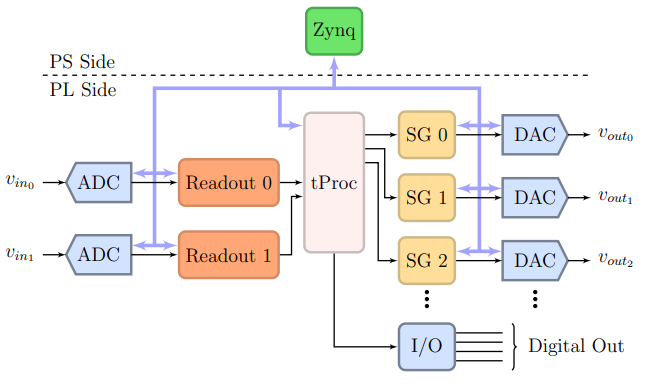

In [33]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v6 - tProc output 7, switch ch 6, maxl

In [35]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_chs'][0])

    for ii, iq in enumerate(iq_list):
        plot = axs[ii]
        if plot_iq:
            plot.plot(t, iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
            plot.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
            plot.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
        else:
            plot.plot(t, iq[0], label="input value, ADC %d"%(config['ro_chs'][ii]))
        plot.set_ylabel("a.u.")
        plot.set_xlabel("Time [us]")
        plot.set_title("Averages = " + str(config["soft_avgs"]))
        plot.legend()
        
def plot_accumulated(iq_list, d_buf, prog, config, span=100):
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    iqs = np.array(iq_list)[:,:,0].T

    for ii, (iq, buf) in enumerate(zip(iqs, d_buf)):
        plot = axs[ii]
        nsamp = prog.ro_chs[ii].length
        center = iq*nsamp
        hrange = [[center[0]-span, center[0]+span],[center[1]-span, center[1]+span]]
        plot.hist2d(buf[:,0], buf[:,1], bins=100, range=hrange, norm=colors.LogNorm())
        plot.set_xlabel("I value, ADC %d"%(config['ro_chs'][ii]))
        plot.set_ylabel("Q value, ADC %d"%(config['ro_chs'][ii]))
        
def noise(prog):
    diq = (prog.di_buf+1j*prog.dq_buf)/prog.ro_chs[0].length
    dmean = np.mean(diq,axis=1)
    dmag = np.abs(dmean)
    drotated = diq*np.exp(-1j*np.angle(dmean))[:,np.newaxis]
    drmsmag = np.std(np.real(drotated),axis=1) # noise in the radial direction
    drmsrot = np.std(np.imag(drotated), axis=1) # noise in the azimuth direction
    return drmsmag, drmsrot

### an example program

In [37]:
class FSGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'], ro_ch=cfg["ro_chs"][0])
            
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg['pulse_freq'],gen_ch=ch,ro_ch=cfg["ro_chs"][0]),
                         gain=cfg['pulse_gain'],
                         phase=0)

            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': 1,
    'ro_sel': 'product',
    'style': 'arb',
    'pulse_gain': 30000,    # a.u.
    'pulse_freq': 80,       # MHz
    'adc_trig_offset': 0.4, # us
    'length': 0.3,          # us
    'readout_padding': 0.1, # us
    'relax_delay': 2,       # us
    'reps': 1,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
print(prog)


// Program

        regwi 2, $22, 49932190;                 //freq = 49932190
        regwi 2, $23, 0;                        //phase = 0
        regwi 2, $25, 30000;                    //gain = 30000
        regwi 2, $24, 0;                        //addr = 0
        regwi 2, $26, 524417;                   //stdysel | mode | outsel = 0b01000 | length = 129 
        regwi 3, $22, 49932190;                 //freq = 49932190
        regwi 3, $23, 0;                        //phase = 0
        regwi 3, $25, 30000;                    //gain = 30000
        regwi 3, $24, 0;                        //addr = 0
        regwi 3, $26, 524417;                   //stdysel | mode | outsel = 0b01000 | length = 129 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $31, 49153;                    //out = 0b1100000000000001
        seti 0, 0, $31, 172;                    //ch =0 out = $31 @t = 0
        seti 0, 0, $0, 182;                     //ch =0 out = 0 @t = 0
   

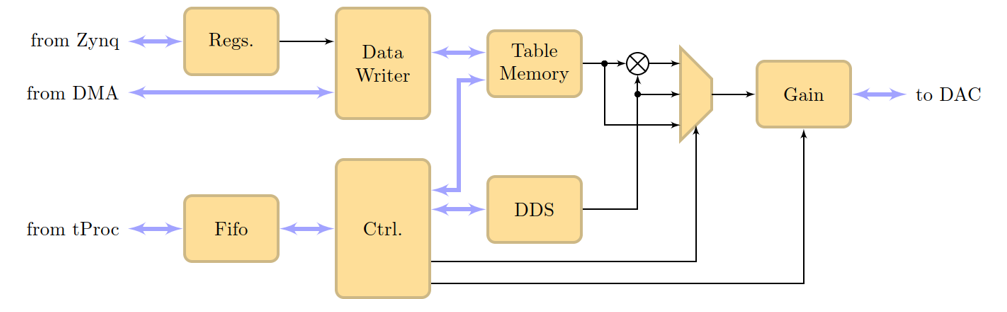

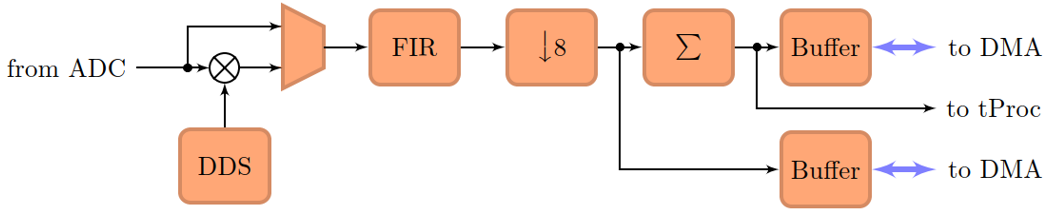

### let's look at low-frequency pulses with direct readout and on the scope

  0%|          | 0/100 [00:00<?, ?it/s]

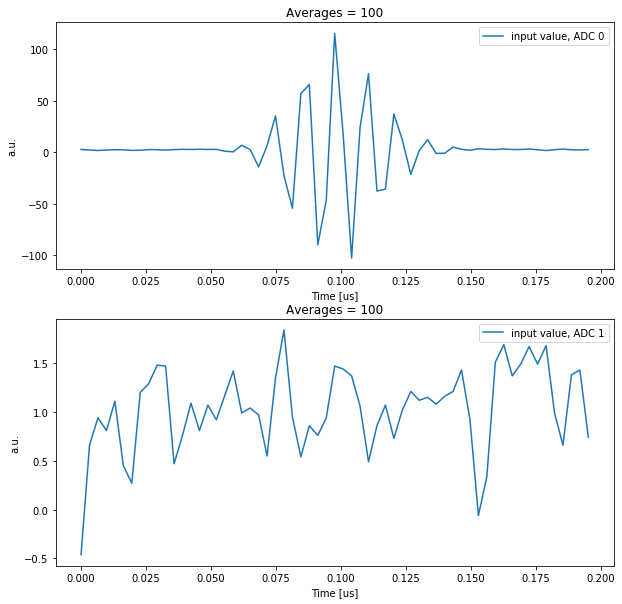

In [46]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': 1,
    'ro_sel': 'input',
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 30000,
    'pulse_freq': 80,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1,
    'soft_avgs': 1
#     'soft_avgs': 100
}
prog = FSGenLoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=False)

### let's look at pulses with downconverted readout, and go to higher frequency
phase coherence!

  0%|          | 0/1000 [00:00<?, ?it/s]

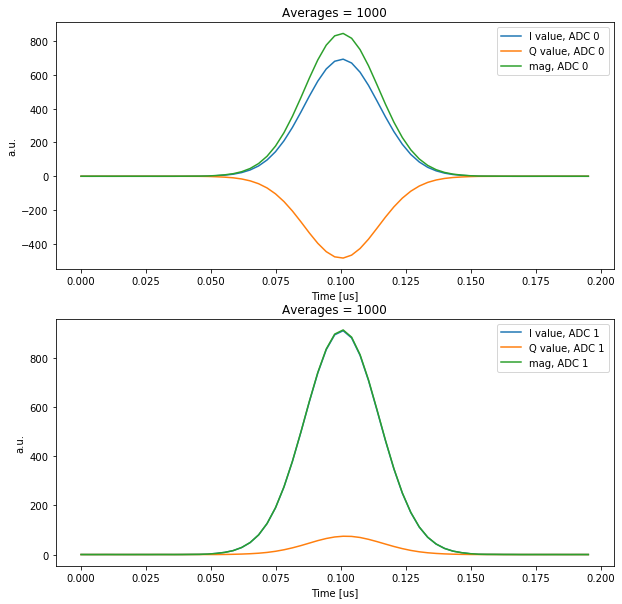

In [53]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'ro_sel': 'product',
    'nqz': 1,
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 32000,
#     'pulse_freq': 80,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1,
#     'soft_avgs': 1
    'soft_avgs': 1000
}
prog = FSGenLoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

### let's switch to accumulated readout
much faster!

In [ ]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': 1,
    'ro_sel': 'product',
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 32000,
#     'pulse_freq': 80,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
#     'reps': 1,
    'reps': 100000,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
prog.acquire(soc, progress=False)
iq_list = prog.acquire(soc, progress=True)
d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)
# Plot results.
plot_accumulated(iq_list, d_buf, prog, config, span=100)

### let's look at the spectrum analyzer - compare Gaussian and square pulse
note 2nd Nyquist image (suppressed by balun and NQZ mode)

In [ ]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': 1,
    'ro_sel': 'product',
    'style': 'const',
#     'style': 'arb',
    'pulse_gain': 32000,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
#     'length': 1,
#     'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1000000,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
while True:
    prog.acquire(soc, progress=True)

### tProc sweep: can sweep any register value

In [ ]:
class GainSweepProgram(RAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'], ro_ch=cfg["ro_chs"][0])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg['pulse_freq'],gen_ch=ch,ro_ch=cfg["ro_chs"][0]),
                         gain=cfg['start'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        for iCh, ch in enumerate(self.cfg["gen_chs"]):
            self.r_rp=self.ch_page(ch)     # get register page for res_ch
            self.r_gain=self.sreg(ch, "gain")   #Get gain register for res_ch
            self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the pulse

config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': 1,
    'ro_sel': 'product',
    'style': 'arb',
    'pulse_gain': 32000,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 2,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1000,
    "expts": 301,
    "start":0, # [DAC units]
    "step":100 # [DAC units]
}

prog =GainSweepProgram(soccfg, config)
print(prog)

expt_pts, avgi, avgq = prog.acquire(soc, load_pulses=True, progress=True)
# Plot results.
fig, axs = plt.subplots(2,1,figsize=(10,10))
for i, plot in enumerate(axs):
    plot = axs[i]

    avgamp0 = np.abs(avgi[i][0] + 1j*avgq[i][0])
    plot.plot(expt_pts, avgi[i][0], label="I value")
    plot.plot(expt_pts, avgq[i][0], label="Q value")
    plot.plot(expt_pts, avgamp0, label="Amplitude")
    plot.set_ylabel("avg a.u.")
    plot.set_xlabel("Pulse gain (DAC units)")
    plot.set_title("Averages = " + str(config["reps"]))
    plot.legend()


### Python loop: can do whatever you want (including sweeping downconversion frequency)
same number of measurements as the previous program

In [ ]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': 1,
    'ro_sel': 'product',
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 2,
    'readout_padding': 0.1,
    'relax_delay': 2,
#     'reps': 1,
    'reps': 1000,
    'soft_avgs': 1
}

freqs = np.linspace(start=0, stop=8000, num=301)
mags = np.zeros((len(freqs),2))
noises = np.zeros((len(freqs),2))

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    res = np.array(res).T[0]
    mags[i] = np.abs(res[:,0]+1j*res[:,1])
    rmsmag, rmsrot = noise(prog)
    noises[i] = rmsmag

fig, axs = plt.subplots(2,1,figsize=(10,10))
for i, plot in enumerate(axs):
    plot = axs[i]
    plot.semilogy(freqs, mags[:,i], label="mean")
    plot.semilogy(freqs, noises[:,i], label="noise")
    plot.set_ylabel("avg a.u.")
    plot.set_xlabel("Frequency [MHz]")
    plot.set_title("Averages = " + str(config["reps"]))
    plot.legend()